# Appendix 1
# Prediction of energy market prices Nord Pool

In this appendix you can see how the best model for Nord Pool prices forecasting was created.

## Importing the Data

In [1]:
from functools import reduce
import glob
import os

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import warnings

from utils import get_time_of_day, get_season

In [2]:
warnings.filterwarnings("ignore")

In [3]:
market_df = pd.read_csv("data/market_data.csv", index_col=0)
market_df.index = pd.to_datetime(market_df.index, utc=True)
print(market_df.shape)
market_df.head()

(11424, 100)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,LT_up_da_cbmp,LT_down_sa_cbmp,LT_down_da_cbmp,EE_dsb,LV_dsb,LT_dsb,EE_imbalance_price,LV_imbalance_price,LT_imbalance_price,10YLT-1001A0008Q_DA_eurmwh
2025-03-01 00:00:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,927.02,120.48
2025-03-01 00:15:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,932.81,120.48
2025-03-01 00:30:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,NaN,NaN,NaN,1,-1.0,1.0,400.00,10.19,119.23,120.48
2025-03-01 00:45:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,400.00,10.19,-303.44,120.48
2025-03-01 01:00:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,560.36,10.19,-291.36,117.15


In [4]:
files = glob.glob("data/weather_location_*.csv")
dfs = []

for file in files:
    city = os.path.splitext(os.path.basename(file))[0].replace("weather_location_", "")
    df = pd.read_csv(file, index_col=0)
    df = df.rename(columns={col: f"{col}_{city}" for col in df.columns})
    
    dfs.append(df)

weather_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs)
weather_df.index = pd.to_datetime(weather_df.index, utc=True)
print(weather_df.shape)
weather_df.head()

(2856, 140)


,wind_speed_80m_Alytus,wind_speed_80m_previous_day1_Alytus,wind_direction_80m_Alytus,wind_direction_80m_previous_day1_Alytus,direct_radiation_Alytus,direct_radiation_previous_day1_Alytus,diffuse_radiation_Alytus,diffuse_radiation_previous_day1_Alytus,cloud_cover_Alytus,cloud_cover_previous_day1_Alytus,...,direct_radiation_Vilnius,direct_radiation_previous_day1_Vilnius,diffuse_radiation_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_Vilnius,relative_humidity_2m_previous_day1_Vilnius
2025-03-01 00:00:00+00:00,13.333627,13.684512,125.0,87.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,2.1235,1.8235,89.0,91.0
2025-03-01 01:00:00+00:00,12.280973,14.737166,123.0,99.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.9735,1.7735,89.0,91.0
2025-03-01 02:00:00+00:00,13.333627,12.631857,118.0,101.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.8735,1.8235,89.0,90.0
2025-03-01 03:00:00+00:00,11.228318,9.473893,130.0,102.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.7735,1.8235,89.0,89.0
2025-03-01 04:00:00+00:00,9.123008,7.368583,152.0,87.0,0.0,0.0,0.0,0.0,100.0,100.0,...,0.0,0.0,0.0,0.0,100.0,100.0,1.9235,1.7235,90.0,90.0


## Cleaning and Preparing the Data for the Model

Since we will only have features availible with `*_previous_day1_*`  lets create a data frame for that. For the market data I will assume that target and predictive values, are aligned correctly but if not we can just move the data to upcomming day (data from 2025-03-01 would go to 2023-03-02), and the issue will be solved.

In [5]:
weather_df.isna().sum().sum()

0

In [6]:
market_df.isna().sum()[market_df.isna().sum() != 0].sort_values(ascending=False).head(40)

LV_up_da_cbmp                10194
LV_down_da_cbmp              10194
LV_procur_afrr_up_price       9718
LV_procur_afrr_down_price     9718
EE_procur_afrr_down_price     9694
EE_procur_afrr_up_price       9694
LT_procur_afrr_up_price       9670
LT_procur_afrr_down_price     9670
EE_procur_afrr_down_vol       9215
EE_procur_afrr_up_vol         9215
LV_procur_afrr_down_vol       9215
LT_procur_afrr_up_vol         9215
LT_procur_afrr_down_vol       9215
LV_procur_afrr_up_vol         9215
LV_procur_mfrr_down_price     8828
LV_procur_mfrr_up_price       8828
LV_procur_mfrr_up_vol         8577
LV_procur_mfrr_down_vol       8577
EE_procur_FCR_price           8568
LT_procur_FCR_price           8568
LT_procur_mfrr_down_vol       8568
LT_procur_mfrr_up_vol         8568
LV_procur_FCR_vol             8568
EE_procur_mfrr_down_vol       8568
EE_procur_mfrr_up_vol         8568
EE_procur_FCR_vol             8568
LT_procur_mfrr_down_price     8568
LT_procur_mfrr_up_price       8568
LT_procur_FCR_vol   

In [7]:
percent_missing = 0.5
market_df_filtered = market_df.loc[:, market_df.isnull().mean() < percent_missing]
print(market_df_filtered.shape)
market_df_filtered.head()

(11424, 68)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,LT_up_da_cbmp,LT_down_sa_cbmp,LT_down_da_cbmp,EE_dsb,LV_dsb,LT_dsb,EE_imbalance_price,LV_imbalance_price,LT_imbalance_price,10YLT-1001A0008Q_DA_eurmwh
2025-03-01 00:00:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,927.02,120.48
2025-03-01 00:15:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,1.0,400.00,10.19,932.81,120.48
2025-03-01 00:30:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,NaN,NaN,NaN,1,-1.0,1.0,400.00,10.19,119.23,120.48
2025-03-01 00:45:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,400.00,10.19,-303.44,120.48
2025-03-01 01:00:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,NaN,27.27,NaN,1,-1.0,-1.0,560.36,10.19,-291.36,117.15


In [8]:
weather_features = [col for col in weather_df.columns if "_previous_day1_" in col]
weather_prev_day_df = weather_df[weather_features]
print(weather_prev_day_df.shape)
weather_prev_day_df.head()

(2856, 70)


,wind_speed_80m_previous_day1_Alytus,wind_direction_80m_previous_day1_Alytus,direct_radiation_previous_day1_Alytus,diffuse_radiation_previous_day1_Alytus,cloud_cover_previous_day1_Alytus,temperature_2m_previous_day1_Alytus,relative_humidity_2m_previous_day1_Alytus,wind_speed_80m_previous_day1_Kaunas,wind_direction_80m_previous_day1_Kaunas,direct_radiation_previous_day1_Kaunas,...,cloud_cover_previous_day1_Utena,temperature_2m_previous_day1_Utena,relative_humidity_2m_previous_day1_Utena,wind_speed_80m_previous_day1_Vilnius,wind_direction_80m_previous_day1_Vilnius,direct_radiation_previous_day1_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_previous_day1_Vilnius
2025-03-01 00:00:00+00:00,13.684512,87.0,0.0,0.0,100.0,0.8285,96.0,16.140705,67.0,0.0,...,100.0,1.398,95.0,13.333627,72.0,0.0,0.0,100.0,1.8235,91.0
2025-03-01 01:00:00+00:00,14.737166,99.0,0.0,0.0,100.0,0.7285,97.0,15.088053,66.0,0.0,...,100.0,1.048,97.0,12.982742,83.0,0.0,0.0,100.0,1.7735,91.0
2025-03-01 02:00:00+00:00,12.631857,101.0,0.0,0.0,100.0,0.7285,96.0,14.386281,60.0,0.0,...,100.0,0.848,98.0,11.930088,87.0,0.0,0.0,100.0,1.8235,90.0
2025-03-01 03:00:00+00:00,9.473893,102.0,0.0,0.0,100.0,0.6285,97.0,14.386281,49.0,0.0,...,100.0,0.798,98.0,10.526547,84.0,0.0,0.0,100.0,1.8235,89.0
2025-03-01 04:00:00+00:00,7.368583,87.0,0.0,0.0,100.0,0.5285,97.0,15.438937,40.0,0.0,...,100.0,0.748,98.0,9.473893,70.0,0.0,0.0,100.0,1.7235,90.0


In [9]:
weather_upsampled = weather_prev_day_df.loc[weather_prev_day_df.index.repeat(4)].copy()
weather_upsampled.index = market_df_filtered.index
merged_df = pd.concat([market_df_filtered, weather_upsampled], axis=1)

print(merged_df.shape)
merged_df.head(8)

(11424, 138)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,cloud_cover_previous_day1_Utena,temperature_2m_previous_day1_Utena,relative_humidity_2m_previous_day1_Utena,wind_speed_80m_previous_day1_Vilnius,wind_direction_80m_previous_day1_Vilnius,direct_radiation_previous_day1_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_previous_day1_Vilnius
2025-03-01 00:00:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,100.0,1.398,95.0,13.333627,72.0,0.0,0.0,100.0,1.8235,91.0
2025-03-01 00:15:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,100.0,1.398,95.0,13.333627,72.0,0.0,0.0,100.0,1.8235,91.0
2025-03-01 00:30:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,100.0,1.398,95.0,13.333627,72.0,0.0,0.0,100.0,1.8235,91.0
2025-03-01 00:45:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,100.0,1.398,95.0,13.333627,72.0,0.0,0.0,100.0,1.8235,91.0
2025-03-01 01:00:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,100.0,1.048,97.0,12.982742,83.0,0.0,0.0,100.0,1.7735,91.0
2025-03-01 01:15:00+00:00,3.061,0.000,3.315,0.0,0.00,2.38,400.0,927.0,-273.0,20.0,...,100.0,1.048,97.0,12.982742,83.0,0.0,0.0,100.0,1.7735,91.0
2025-03-01 01:30:00+00:00,2.250,0.000,3.379,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,100.0,1.048,97.0,12.982742,83.0,0.0,0.0,100.0,1.7735,91.0
2025-03-01 01:45:00+00:00,0.517,0.684,1.854,0.0,0.00,2.42,400.0,927.0,-273.0,20.0,...,100.0,1.048,97.0,12.982742,83.0,0.0,0.0,100.0,1.7735,91.0


In [10]:
df = merged_df.copy()

df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month
df["time_of_day"] = df["hour"].apply(get_time_of_day)
df["season"] = df["month"].apply(get_season)
df["time_of_day"] = df["time_of_day"].astype("category")
df["season"] = df["season"].astype("category")

print(df.shape)
df.head()

(11424, 143)


,EE_afrr_up_activ,EE_afrr_down_activ,LV_afrr_up_activ,LV_afrr_down_activ,LT_afrr_up_activ,LT_afrr_down_activ,EE_afrr_up_min_bid,EE_afrr_up_max_bid,EE_afrr_down_min_bid,EE_afrr_down_max_bid,...,direct_radiation_previous_day1_Vilnius,diffuse_radiation_previous_day1_Vilnius,cloud_cover_previous_day1_Vilnius,temperature_2m_previous_day1_Vilnius,relative_humidity_2m_previous_day1_Vilnius,hour,dayofweek,month,time_of_day,season
2025-03-01 00:00:00+00:00,1.818,0.018,3.048,0.0,2.05,0.00,400.0,927.0,-273.0,20.0,...,0.0,0.0,100.0,1.8235,91.0,0,5,3,night,spring
2025-03-01 00:15:00+00:00,1.729,0.000,3.547,0.0,2.40,0.00,400.0,400.0,-273.0,20.0,...,0.0,0.0,100.0,1.8235,91.0,0,5,3,night,spring
2025-03-01 00:30:00+00:00,1.070,0.000,3.506,0.0,0.38,1.50,400.0,927.0,-273.0,20.0,...,0.0,0.0,100.0,1.8235,91.0,0,5,3,night,spring
2025-03-01 00:45:00+00:00,0.604,0.221,1.828,0.0,0.00,2.48,400.0,927.0,-273.0,20.0,...,0.0,0.0,100.0,1.8235,91.0,0,5,3,night,spring
2025-03-01 01:00:00+00:00,2.829,0.000,2.324,0.0,0.00,1.75,400.0,927.0,-273.0,20.0,...,0.0,0.0,100.0,1.7735,91.0,1,5,3,night,spring


In [11]:
targets = ["10YLT-1001A0008Q_DA_eurmwh", "LT_up_sa_cbmp", "LT_down_sa_cbmp"]
features =  [col for col in df.columns if col not in targets]

# It is sorted by time but better safe than sorry
df = df.sort_index()

split_idx = int(len(df) * 0.8)
X_train = df[features].iloc[:split_idx]
y_train = df[targets[0]].iloc[:split_idx]
X_test = df[features].iloc[split_idx:]
y_test = df[targets[0]].iloc[split_idx:]

In [18]:
df["10YLT-1001A0008Q_DA_eurmwh"].isna().sum()

0

# Nord Pool prices forecasting model in day-ahead setting
## XGBoost

Here I will choose to optimize the parameters of the XGBoost model on Mean Average Error (MAE) and I will evaluate some price specific metrics of the best model in the main notebook. 

In [12]:
model_xgb = XGBRegressor(
    random_state=9,
    subsample=0.8,
    enable_categorical=True,
    tree_method="hist",
    n_jobs=-1
)

param_grid_xgb = {
    "n_estimators": [300, 400, 500],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.025, 0.05],
    "colsample_bytree": [0.4, 0.5, 0.6],
}


tscv = TimeSeriesSplit(n_splits=3)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid_search_xgb = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid_xgb,  
    scoring=mae_scorer,
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

grid_search_xgb.fit(X_train, y_train)

print("Best parameters:", grid_search_xgb.best_params_)
print("Best MAE CV:", -grid_search_xgb.best_score_)
y_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test)
mae_test_xgb = mean_absolute_error(y_test, y_pred_xgb)
print("Test MAE:", round(mae_test_xgb, 4))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.025, 'max_depth': 4, 'n_estimators': 400}
Best MAE CV: 26.467078098074335
Test MAE: 19.719


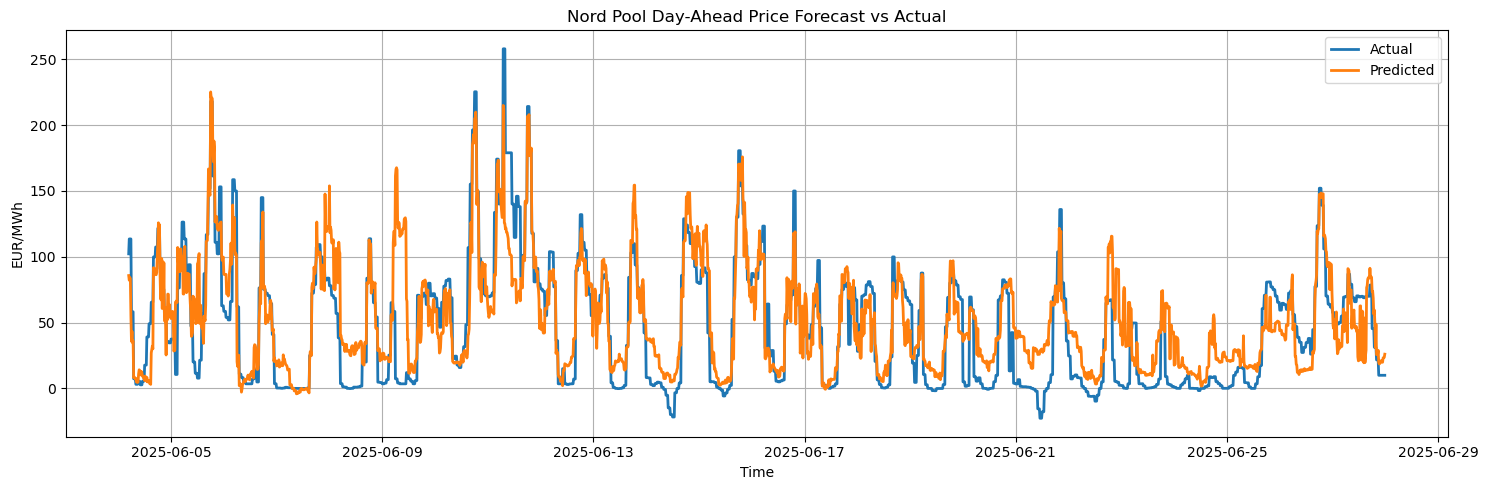

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred_xgb, label="Predicted", linewidth=2)
plt.title("Nord Pool Day-Ahead Price Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("EUR/MWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Top 10 features XGBoost:
LT_mfrr_SA_down_max_bid                    0.123675
EE_mfrr_SA_down_max_bid                    0.082882
diffuse_radiation_previous_day1_Telsiai    0.047582
EE_mfrr_SA_up_min_bid                      0.046531
LV_mfrr_SA_down_max_bid                    0.040506
LT_mfrr_SA_down_min_bid                    0.031494
month                                      0.029021
LT_mfrr_SA_up_max_bid                      0.028669
diffuse_radiation_previous_day1_Taurage    0.026593
diffuse_radiation_previous_day1_Kaunas     0.025863
dtype: float32


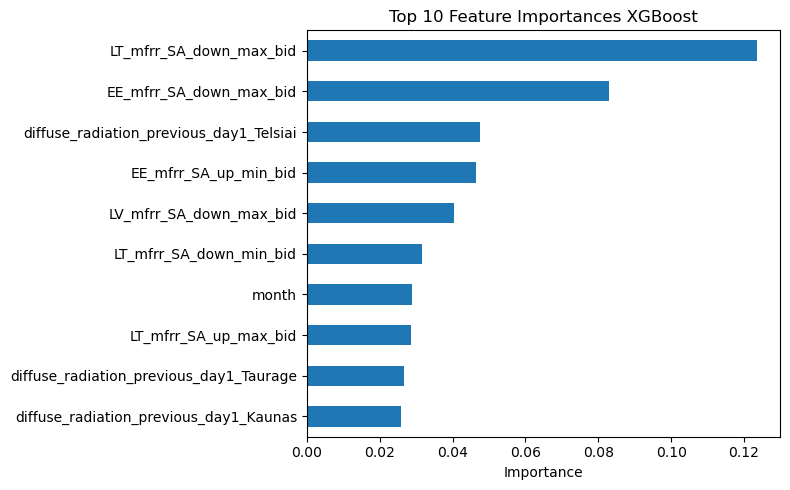

In [14]:
best_model_xgb = grid_search_xgb.best_estimator_

if hasattr(best_model_xgb, "feature_names_in_"):
    feature_names = best_model_xgb.feature_names_in_
else:
    feature_names = X_train.columns

importances_xgb = pd.Series(
    best_model_xgb.feature_importances_, index=feature_names
).sort_values(ascending=False)

print("Top 10 features XGBoost:")
print(importances_xgb.head(10))

importances_xgb.head(10).plot(
    kind="barh", figsize=(8, 5), title="Top 10 Feature Importances XGBoost"
)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

The best-performing model was obtained with the following parameters:
{'regressor__learning_rate': 0.05, 'regressor__n_estimators': 300, 'regressor__num_leaves': 31}.

The model demonstrates strong forecasting ability for the near future, with performance gradually decreasing as the prediction horizon extends further. This decline in longer-term accuracy is not a concern for our use case, as our primary objective is short-term forecasting. Furthermore, the model can be periodically retrained to maintain high accuracy for near-term predictions.

# Prediction of energy market prices mFRR

# Summary